<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_sep_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew, boxcox_normmax

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_test.csv')

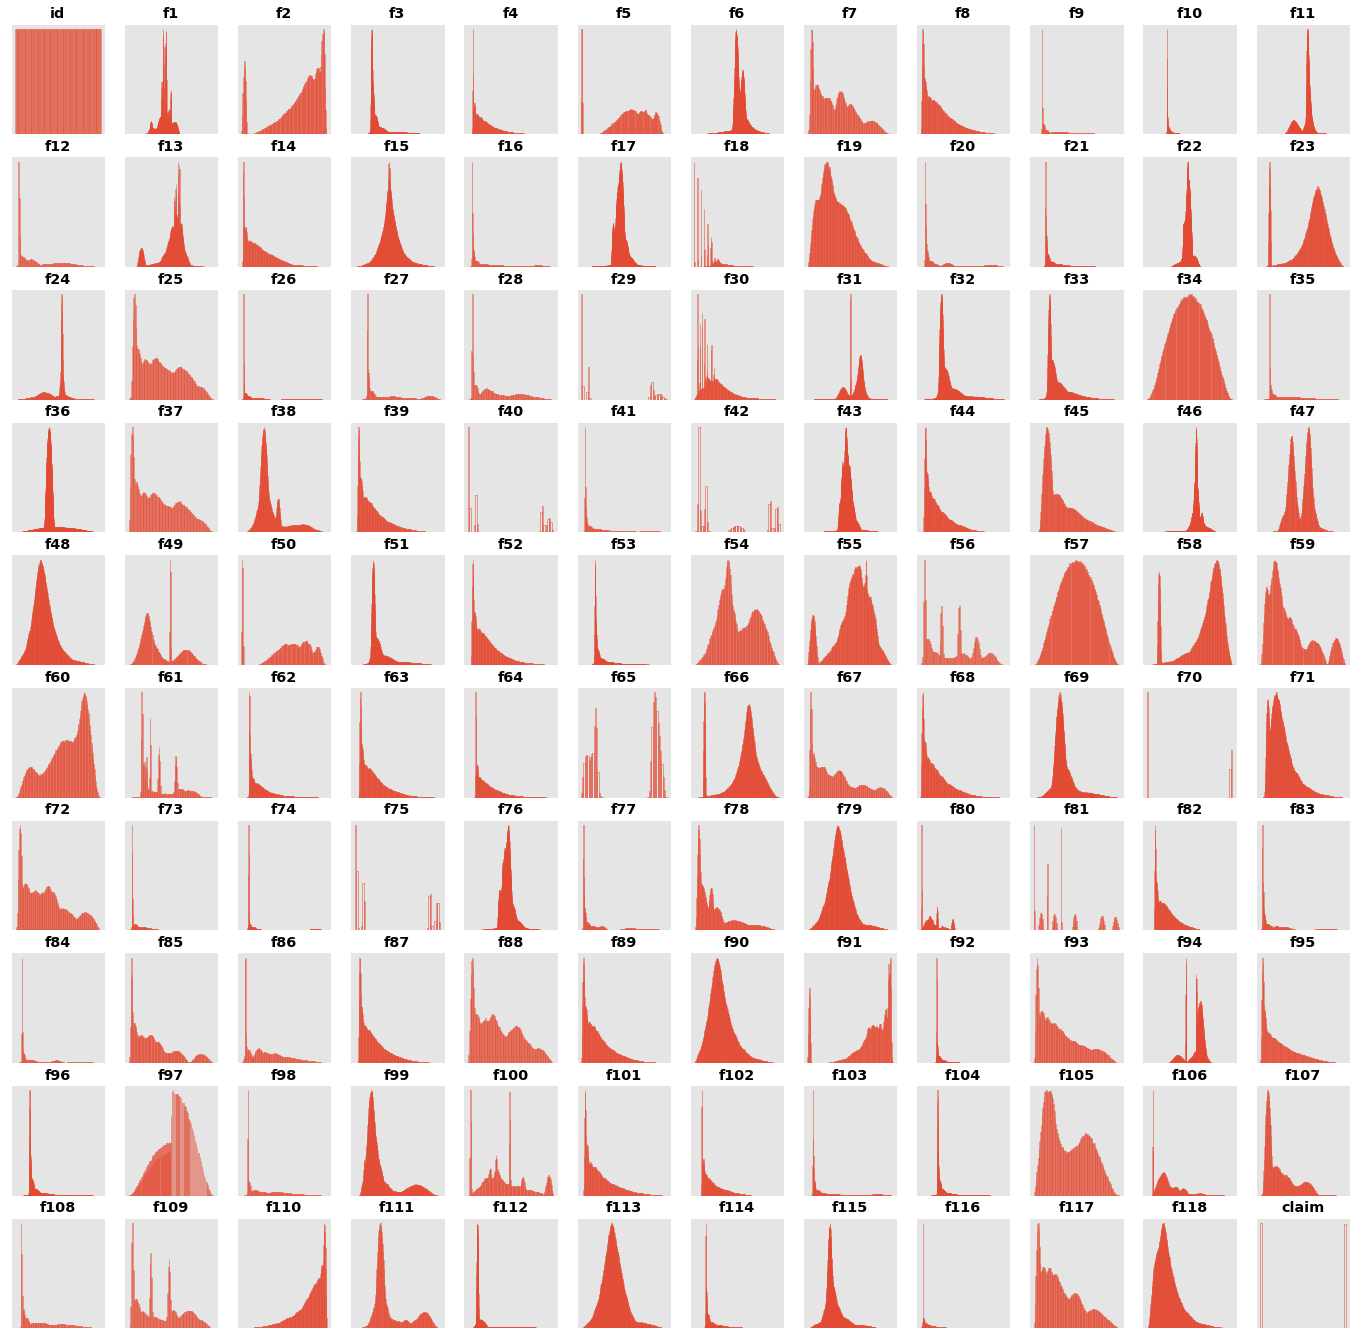

In [ ]:
plt.figure(figsize=(24,24))
for i, j in enumerate(train.columns):
  plt.subplot(10, 12, i+1)
  sns.histplot(x=train[j], fill=False)
  plt.xlabel('')
  plt.ylabel('')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'{j}', fontweight='bold')

In [3]:
train['na'] = train.isnull().sum(axis=1)
test['na'] = test.isnull().sum(axis=1)

In [ ]:
!pip install catboost
!pip install optuna

In [4]:
from sklearn.impute import SimpleImputer
import catboost
import optuna
import lightgbm
import xgboost
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# data splits

x_train = train.drop(columns=['claim', 'id'])
y_train = train['claim']
x_test = test.drop(columns=['id'])

train_columns = x_train.columns
test_columns = x_test.columns

In [6]:
# 누락값(impute)
x_train = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(x_train), columns=train_columns)
x_test = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(x_test), columns=test_columns)

In [7]:
# scaling
sc = StandardScaler().fit(x_train)
x_train = pd.DataFrame(sc.transform(x_train), columns=train_columns)
x_test = pd.DataFrame(sc.transform(x_test), columns=test_columns)

# mc = MinMaxScaler().fit(x_train)
# x_train = pd.DataFrame(mc.transform(x_train), columns=train_columns)
# x_test = pd.DataFrame(mc.transform(x_test), columns=test_columns)

# Catboost [LB : 0.81691]

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(eval_metric='AUC', task_type='GPU', iterations=5000)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

In [8]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 40000, step=1000),
              'task_type':"GPU",
              'eval_metric':'AUC',
              'objective':'CrossEntropy',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
               }
    model = catboost.CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [9]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-09-16 04:23:08,611] A new study created in memory with name: no-name-5a7be863-2d0a-4e82-841e-fed9cc7a7c19
[I 2021-09-16 04:24:23,708] Trial 0 finished with value: 0.8126050890622862 and parameters: {'iterations': 2000, 'learning_rate': 0.15666492887561392, 'reg_lambda': 50.79504158837042, 'subsample': 0.33096179112749147, 'random_strength': 26.802885935208383, 'depth': 5, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 10}. Best is trial 0 with value: 0.8126050890622862.
[I 2021-09-16 04:24:39,644] Trial 1 finished with value: 0.8011171151217659 and parameters: {'iterations': 30000, 'learning_rate': 0.2540072303942089, 'reg_lambda': 30.520610739067664, 'subsample': 0.8137517515739099, 'random_strength': 42.37790759847343, 'depth': 13, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 8}. Best is trial 0 with value: 0.8126050890622862.
[I 2021-09-16 04:24:51,738] Trial 2 finished with value: 0.8057372111903748 and parameters: {'iterations': 19000, 'learning_rate': 0.27

Number of finished trials: 50
Best trial: score 0.8148113422084914, params {'iterations': 9000, 'learning_rate': 0.04450195814395664, 'reg_lambda': 18.074939714295926, 'subsample': 0.7698578624188435, 'random_strength': 19.412208983283282, 'depth': 2, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 4}


In [10]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_cat = {
    'iterations'  :study.best_params['iterations'],
    'task_type':"GPU",
    'eval_metric':'AUC',
    'objective':'CrossEntropy',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth':study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Depthwise'
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

0:	learn: 0.7971736	test: 0.7971951	best: 0.7971951 (0)	total: 13.2ms	remaining: 1m 58s
100:	learn: 0.8068334	test: 0.8049523	best: 0.8049523 (100)	total: 1.12s	remaining: 1m 38s
200:	learn: 0.8098847	test: 0.8072736	best: 0.8072736 (200)	total: 2.19s	remaining: 1m 36s
300:	learn: 0.8114895	test: 0.8084622	best: 0.8084622 (300)	total: 3.29s	remaining: 1m 34s
400:	learn: 0.8127043	test: 0.8094715	best: 0.8094715 (400)	total: 4.38s	remaining: 1m 33s
500:	learn: 0.8137108	test: 0.8102443	best: 0.8102443 (500)	total: 5.44s	remaining: 1m 32s
600:	learn: 0.8144543	test: 0.8109004	best: 0.8109004 (600)	total: 6.52s	remaining: 1m 31s
700:	learn: 0.8150372	test: 0.8113679	best: 0.8113679 (700)	total: 7.59s	remaining: 1m 29s
800:	learn: 0.8154748	test: 0.8116826	best: 0.8116826 (800)	total: 8.67s	remaining: 1m 28s
900:	learn: 0.8159011	test: 0.8119484	best: 0.8119484 (900)	total: 9.74s	remaining: 1m 27s
1000:	learn: 0.8163250	test: 0.8122716	best: 0.8122716 (1000)	total: 10.8s	remaining: 1m 26s


# LGBM [LB : 0.81742]

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM

!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

In [11]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
            "n_estimators": trial.suggest_int('n_estimators', 2000, 40000, step=500),
            "objective": "binary",
            "metric": "AUC", 
            "verbosity": -1,
            
            "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 1.0),
            "reg_alpha": trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
            "reg_lambda": trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
            "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            "subsample": trial.suggest_uniform('subsample', 0.4, 1.0),
            "subsample_freq": trial.suggest_categorical("subsample_freq", [1,2]),
            "max_depth": trial.suggest_int('max_depth', 1, 14),
            "num_leaves" : trial.suggest_int('num_leaves', 2, 256),
            "min_child_weight" : trial.suggest_categorical("min_child_weight", [128,256]),
            "min_child_samples": trial.suggest_int('min_child_samples', 1, 200),
            "device": "gpu"
        }
    model = lightgbm.LGBMClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [12]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-09-16 04:58:15,524] A new study created in memory with name: no-name-87b09bdc-f7e9-4a64-8344-3c2f9c6a8f8a
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[I 2021-09-16 04:58:48,149] Trial 0 finished with value: 0.8094972940910101 and parameters: {'n_estimators': 10500, 'learning_rate': 0.17400509677136938, 'reg_alpha': 4.754459598404485, 'reg_lambda': 0.24330534076155272, 'colsample_bytree': 0.7428725248235708, 'subsample': 0.9996485552329413, 'subsample_freq': 2, 'max_depth': 13, 'num_leaves': 228, 'min_child_weight': 128, 'min_child_samples': 197}. Best 

Number of finished trials: 50
Best trial: score 0.8151702561443545, params {'n_estimators': 32500, 'learning_rate': 0.015476312230552137, 'reg_alpha': 6.203959275837573, 'reg_lambda': 8.061326570356217, 'colsample_bytree': 0.6430314107424353, 'subsample': 0.8169170201963729, 'subsample_freq': 1, 'max_depth': 4, 'num_leaves': 46, 'min_child_weight': 256, 'min_child_samples': 48}


In [13]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_lgbm = {
    "n_estimators": study.best_params['n_estimators'],
    "objective": "binary",
    "metric": "AUC", 
    "verbosity": -1,
    "learning_rate": study.best_params['learning_rate'],
    "reg_alpha": study.best_params['reg_alpha'],
    "reg_lambda": study.best_params['reg_lambda'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": study.best_params['subsample_freq'],
    "max_depth": study.best_params['max_depth'],
    "num_leaves" : study.best_params['num_leaves'],
    "min_child_weight" : study.best_params['min_child_weight'],
    "min_child_samples": study.best_params['min_child_samples'],
    "device": "gpu" 
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgbm = lightgbm.LGBMClassifier(**params_lgbm)
  model_lgbm.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_lgbm.predict_proba(x_test)[:,1] / sf.n_splits

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	valid_0's auc: 0.805281
[200]	valid_0's auc: 0.80689
[300]	valid_0's auc: 0.807978
[400]	valid_0's auc: 0.808903
[500]	valid_0's auc: 0.809748
[600]	valid_0's auc: 0.810489
[700]	valid_0's auc: 0.811018
[800]	valid_0's auc: 0.811502
[900]	valid_0's auc: 0.8119
[1000]	valid_0's auc: 0.812257
[1100]	valid_0's auc: 0.812496
[1200]	valid_0's auc: 0.812729
[1300]	valid_0's auc: 0.812945
[1400]	valid_0's auc: 0.813125
[1500]	valid_0's auc: 0.813334
[1600]	valid_0's auc: 0.813525
[1700]	valid_0's auc: 0.813687
[1800]	valid_0's auc: 0.813832
[1900]	valid_0's auc: 0.813965
[2000]	valid_0's auc: 0.814095
[2100]	valid_0's auc: 0.814186
[2200]	valid_0's auc: 0.814305
[2300]	valid_0's auc: 0.814397
[2400]	valid_0's auc: 0.814474
[2500]	valid_0's auc: 0.814561
[2600]	valid_0's auc: 0.814636
[2700]	valid_0's auc: 0.814721
[2800]	valid_0's auc: 0.814807
[2900]	valid_0's auc: 0.814873
[3000]	valid_0's auc: 0.814962
[3100]	valid_0's auc: 0.815009
[3200]	valid_0's auc: 0.815065
[3300]	valid_0's auc

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	valid_0's auc: 0.806049
[200]	valid_0's auc: 0.808252
[300]	valid_0's auc: 0.809353
[400]	valid_0's auc: 0.810347
[500]	valid_0's auc: 0.811385
[600]	valid_0's auc: 0.812123
[700]	valid_0's auc: 0.81262
[800]	valid_0's auc: 0.813089
[900]	valid_0's auc: 0.813457
[1000]	valid_0's auc: 0.813799
[1100]	valid_0's auc: 0.814091
[1200]	valid_0's auc: 0.814327
[1300]	valid_0's auc: 0.814551
[1400]	valid_0's auc: 0.814686
[1500]	valid_0's auc: 0.814841
[1600]	valid_0's auc: 0.815004
[1700]	valid_0's auc: 0.815114
[1800]	valid_0's auc: 0.815214
[1900]	valid_0's auc: 0.815354
[2000]	valid_0's auc: 0.815464
[2100]	valid_0's auc: 0.81554
[2200]	valid_0's auc: 0.815625
[2300]	valid_0's auc: 0.815703
[2400]	valid_0's auc: 0.815814
[2500]	valid_0's auc: 0.815876
[2600]	valid_0's auc: 0.815945
[2700]	valid_0's auc: 0.816
[2800]	valid_0's auc: 0.816077
[2900]	valid_0's auc: 0.816143
[3000]	valid_0's auc: 0.816186
[3100]	valid_0's auc: 0.816242
[3200]	valid_0's auc: 0.816276
[3300]	valid_0's auc: 

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	valid_0's auc: 0.804605
[200]	valid_0's auc: 0.806847
[300]	valid_0's auc: 0.808168
[400]	valid_0's auc: 0.809135
[500]	valid_0's auc: 0.810081
[600]	valid_0's auc: 0.810812
[700]	valid_0's auc: 0.811326
[800]	valid_0's auc: 0.811775
[900]	valid_0's auc: 0.812158
[1000]	valid_0's auc: 0.812452
[1100]	valid_0's auc: 0.81264
[1200]	valid_0's auc: 0.812904
[1300]	valid_0's auc: 0.813074
[1400]	valid_0's auc: 0.813268
[1500]	valid_0's auc: 0.813457
[1600]	valid_0's auc: 0.813598
[1700]	valid_0's auc: 0.813698
[1800]	valid_0's auc: 0.813845
[1900]	valid_0's auc: 0.81396
[2000]	valid_0's auc: 0.814093
[2100]	valid_0's auc: 0.814211
[2200]	valid_0's auc: 0.814299
[2300]	valid_0's auc: 0.814389
[2400]	valid_0's auc: 0.814481
[2500]	valid_0's auc: 0.814553
[2600]	valid_0's auc: 0.814657
[2700]	valid_0's auc: 0.814729
[2800]	valid_0's auc: 0.814813
[2900]	valid_0's auc: 0.814893
[3000]	valid_0's auc: 0.814956
[3100]	valid_0's auc: 0.815029
[3200]	valid_0's auc: 0.815108
[3300]	valid_0's au

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	valid_0's auc: 0.804911
[200]	valid_0's auc: 0.807359
[300]	valid_0's auc: 0.808398
[400]	valid_0's auc: 0.809381
[500]	valid_0's auc: 0.810168
[600]	valid_0's auc: 0.810754
[700]	valid_0's auc: 0.811252
[800]	valid_0's auc: 0.811747
[900]	valid_0's auc: 0.812148
[1000]	valid_0's auc: 0.812434
[1100]	valid_0's auc: 0.812686
[1200]	valid_0's auc: 0.812895
[1300]	valid_0's auc: 0.813149
[1400]	valid_0's auc: 0.813353
[1500]	valid_0's auc: 0.813507
[1600]	valid_0's auc: 0.813657
[1700]	valid_0's auc: 0.813769
[1800]	valid_0's auc: 0.813931
[1900]	valid_0's auc: 0.81403
[2000]	valid_0's auc: 0.814145
[2100]	valid_0's auc: 0.814283
[2200]	valid_0's auc: 0.814411
[2300]	valid_0's auc: 0.814515
[2400]	valid_0's auc: 0.814607
[2500]	valid_0's auc: 0.814693
[2600]	valid_0's auc: 0.814765
[2700]	valid_0's auc: 0.81483
[2800]	valid_0's auc: 0.814884
[2900]	valid_0's auc: 0.814929
[3000]	valid_0's auc: 0.814994
[3100]	valid_0's auc: 0.815053
[3200]	valid_0's auc: 0.815106
[3300]	valid_0's au

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:723: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:733: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[100]	valid_0's auc: 0.804881
[200]	valid_0's auc: 0.806785
[300]	valid_0's auc: 0.807829
[400]	valid_0's auc: 0.808719
[500]	valid_0's auc: 0.809485
[600]	valid_0's auc: 0.810162
[700]	valid_0's auc: 0.810724
[800]	valid_0's auc: 0.811145
[900]	valid_0's auc: 0.811472
[1000]	valid_0's auc: 0.811755
[1100]	valid_0's auc: 0.812016
[1200]	valid_0's auc: 0.812203
[1300]	valid_0's auc: 0.812387
[1400]	valid_0's auc: 0.812547
[1500]	valid_0's auc: 0.812699
[1600]	valid_0's auc: 0.812853
[1700]	valid_0's auc: 0.813014
[1800]	valid_0's auc: 0.81314
[1900]	valid_0's auc: 0.813213
[2000]	valid_0's auc: 0.813294
[2100]	valid_0's auc: 0.813395
[2200]	valid_0's auc: 0.813478
[2300]	valid_0's auc: 0.813551
[2400]	valid_0's auc: 0.813634
[2500]	valid_0's auc: 0.813725
[2600]	valid_0's auc: 0.813809
[2700]	valid_0's auc: 0.81389
[2800]	valid_0's auc: 0.813947
[2900]	valid_0's auc: 0.814006
[3000]	valid_0's auc: 0.814071
[3100]	valid_0's auc: 0.814124
[3200]	valid_0's auc: 0.814174
[3300]	valid_0's au

# XGBoost

In [14]:
def objective(trial, data=x_train, target=y_train):

  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
  params = {
      'n_estimators' : trial.suggest_int('n_estimators', 2000, 40000, step=500),
      'objective' : trial.suggest_categorical('objective', ['binary:logistic', 'binary:logitraw', 'binary:hinge']),
      'eval_metric' : 'auc',
      'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 0.8),
      'reg_alpha' : trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
      'reg_lambda' : trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
      'colsample_bytree' : trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
      'subsample' : trial.suggest_uniform('subsample', 0.4, 1.0),
      'subsample_freq' : trial.suggest_categrical('subsample_freq', [1,2]),
      'max_depth' : trial.suggest_int('max_depth', 1, 14),
      'num_leaves' : trial.suggest_int('num_leaves', 2, 256),
      'min_child_weight' : trial.suggest_categorical('min_child_weight', [128, 256]),
      'min_child_sample' : trial.suggest_int('min_child_sample', 1, 200),
      'tree_method' : 'gpu_hist',
      # 'grow_policy' : 'lossguide'
   }
  model = xgboost.XGBClassifier(**params)
  model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

  y_preds = model.predict_proba(X_test)[:,1]

  AUC = roc_auc_score(y_test, y_preds)

  return AUC

In [15]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
            "n_estimators": trial.suggest_int('n_estimators', 2000, 40000, step=500),
            "objective": trial.suggest_categorical('objective', ["binary:logistic", 'binary:logitraw', 'binary:hinge']),
            "eval_metric": "auc",
            "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 1.0),
            "reg_alpha": trial.suggest_uniform('reg_alpha', 1e-3, 10.0),
            "reg_lambda": trial.suggest_uniform('reg_lambda', 1e-3, 10.0),
            "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            "subsample": trial.suggest_uniform('subsample', 0.4, 1.0),
            "subsample_freq": trial.suggest_categorical("subsample_freq", [1,2]),
            "max_depth": trial.suggest_int('max_depth', 1, 14),
            "num_leaves" : trial.suggest_int('num_leaves', 2, 256),
            "min_child_weight" : trial.suggest_categorical("min_child_weight", [128,256]),
            "min_child_samples": trial.suggest_int('min_child_samples', 1, 200),
            'tree_method' : 'gpu_hist',
            # 'grow_policy' : 'lossguide' 
        }
    model = xgboost.XGBClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [17]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-09-16 07:57:27,926] A new study created in memory with name: no-name-c338541a-96fd-4150-baa1-27c662ad8b5e
[I 2021-09-16 07:57:41,227] Trial 0 finished with value: 0.8103769947539634 and parameters: {'n_estimators': 12500, 'objective': 'binary:logitraw', 'learning_rate': 0.27935863504183633, 'reg_alpha': 9.915152154531881, 'reg_lambda': 1.565472149929376, 'colsample_bytree': 0.8455464442424991, 'subsample': 0.7238010663061154, 'subsample_freq': 2, 'max_depth': 7, 'num_leaves': 189, 'min_child_weight': 256, 'min_child_samples': 93}. Best is trial 0 with value: 0.8103769947539634.
[I 2021-09-16 07:57:50,340] Trial 1 finished with value: 0.8093974292476598 and parameters: {'n_estimators': 3500, 'objective': 'binary:logitraw', 'learning_rate': 0.7054722717801715, 'reg_alpha': 3.8610843033270124, 'reg_lambda': 2.5723374917816524, 'colsample_bytree': 0.4609321668312011, 'subsample': 0.8690783181860402, 'subsample_freq': 2, 'max_depth': 4, 'num_leaves': 167, 'min_child_weight': 256, 'm

Number of finished trials: 50
Best trial: score 0.8150496641347108, params {'n_estimators': 35000, 'objective': 'binary:logitraw', 'learning_rate': 0.006334001085316388, 'reg_alpha': 8.441648220400477, 'reg_lambda': 9.212698582500694, 'colsample_bytree': 0.6953037260901678, 'subsample': 0.9179680557479282, 'subsample_freq': 1, 'max_depth': 5, 'num_leaves': 243, 'min_child_weight': 256, 'min_child_samples': 20}


In [18]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_xgb = {
    "n_estimators": study.best_params['n_estimators'],
    "objective": study.best_params['objective'],
    "eval_metric": "auc",
    "learning_rate": study.best_params['learning_rate'],
    "reg_alpha": study.best_params['reg_alpha'],
    "reg_lambda": study.best_params['reg_lambda'],
    "colsample_bytree": study.best_params['colsample_bytree'],
    "subsample": study.best_params['subsample'],
    "subsample_freq": study.best_params['subsample_freq'],
    "max_depth": study.best_params['max_depth'],
    "num_leaves" : study.best_params['num_leaves'],
    "min_child_weight" : study.best_params['min_child_weight'],
    "min_child_samples": study.best_params['min_child_samples'],
    'tree_method' : 'gpu_hist',
     # 'grow_policy' : 'lossguide' 
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict_proba(x_test)[:,1] / sf.n_splits

[0]	validation_0-auc:0.536317	validation_1-auc:0.533945
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 70 rounds.
[100]	validation_0-auc:0.807494	validation_1-auc:0.804695
[200]	validation_0-auc:0.809793	validation_1-auc:0.80583
[300]	validation_0-auc:0.811406	validation_1-auc:0.806743
[400]	validation_0-auc:0.812727	validation_1-auc:0.807466
[500]	validation_0-auc:0.813776	validation_1-auc:0.807929
[600]	validation_0-auc:0.814799	validation_1-auc:0.808449
[700]	validation_0-auc:0.815715	validation_1-auc:0.808863
[800]	validation_0-auc:0.81655	validation_1-auc:0.80928
[900]	validation_0-auc:0.817404	validation_1-auc:0.809745
[1000]	validation_0-auc:0.818165	validation_1-auc:0.810111
[1100]	validation_0-auc:0.818881	validation_1-auc:0.810434
[1200]	validation_0-auc:0.819517	validation_1-auc:0.810752
[1300]	validation_0-auc:0.820141	validation_1-auc:0.811071
[1400]	validation_0-auc:0.820686

In [19]:
cat = model_cat(**params_cat)
xgb = model_xgb(**params_xgb)
lgb = model_lgb(**params_lgb)

TypeError: ignored

# To Do

- 스택킹 필사하기

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_sample_solution.csv')
submit['claim'] = preds
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/submit6.csv', index=False)
submit

,id,claim
0,957919,0.584806
1,957920,0.121539
2,957921,0.629069
3,957922,0.127778
4,957923,0.152864
...,...,...
493469,1451388,0.823289
493470,1451389,0.111646
493471,1451390,0.756025
493472,1451391,0.136460
